# Spotify Project


Group Members:
Andrew Holmes, Avery Le, Tor Weiland, J.P. Pacheaco

Project Idea:
  - Given a users Playlist of liked and Disliked song, use the Spotify API and Machine Learning to recommend similar songs to the user. We determined similarity by taking the euclidean distance between song features.

Project Description:

  - Get all songs from the top 1000 Streamed Artists on Spotify
  - Use the Spotipy Web Developers program to access the Spotify Web API
  - Download all songs available for the 1000 Artists
  - Import a users Spotify PLaylist via URL (like and dislike)
  - Get all data about the songs and preform a clustering model on it
  - Using KMeans, like in class, we first found the numebr of clusters using elbow technique
  - Validate that our input playlist has distinct clusters
  - Cluster the main all songs data frame
  - See which cluster has the most known liked songs in it and recommend those songs

## Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

## Using the Spotify API

In [ ]:
#Install the spotipy software to use the Spotify API
!pip install spotipy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  - The Spotify API requires you to get Client Credentials through their Spotify Web Developers website

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import numpy as np


#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id='', client_secret='')
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

#sp - spotify object 
sp

  - The following code are the functions used to scrape the Spotify API to get the songs of each artist

In [ ]:
# Using this function to input an artist's name and return all the songs by that artist
from tqdm import tqdm_notebook
def artist_tracks(artists):

    # Each list in this list will be a track and its features
    tracks = []
    
    
    
    for artist in tqdm_notebook(artists):
        

        # Get the artist URI (a unique ID)
        artist_uri = sp.search(artist)['tracks']['items'][0]['artists'][0]['uri']
        
        # Spotify has a lot of duplicate albums, but we'll cross-reference them with this list to avoid extra loops
        album_checker = []
        
        # The starting point of our loop of albums for those artists with more than 50
        n = 0
        
        

        # Note the album_type = 'album'. This discounts singles, compilations and collaborations
        while len(sp.artist_albums(artist_uri, album_type = 'album', limit=50, offset = n)['items']) > 0:
            
            # Avoid overloading Spotify with requests by assigning the list of album dictionaries to a variable
            dict_list = sp.artist_albums(artist_uri, album_type = 'album', limit=50, offset = n)['items']
            
            

            for i, album in tqdm_notebook(enumerate(dict_list)):

                

                # Add the featured artists for the album in question to the checklist
                check_this_album = [j['name'] for j in dict_list[i]['artists']]
                # And the album name
                check_this_album.append(dict_list[i]['name'])
                # And its date
                check_this_album.append(dict_list[i]['release_date'])

                # Only continue looping if that album isn't in the checklist
                if check_this_album not in album_checker:
                    
                    # Add this album to the checker
                    album_checker.append(check_this_album)
                    # For every song on the album, get its descriptors and features in a list and add to the tracklist
                    
                    try:
                      tracks.extend([[artist, album['name'], album['uri'], song['name'],
                    
                        album['release_date']] + list(sp.audio_features(song['uri'])[0].values())
                                    for song in sp.album_tracks(album['uri'])['items']])
                    except:
                      print(artists)
            
            # Go through the next 50 albums (otherwise we'll get an infinite while loop)
            n += 50

    return tracks

In [ ]:

#This function is cleaning the data and putting it in a pandas dataframe
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

def df_tracks(tracklist):

    df = pd.DataFrame(tracklist, columns=['artist',
     'album_name',
     'album_uri',
     'track',
     'release_date'] + list(sp.audio_features('7tr2za8SQg2CI8EDgrdtNl')[0].keys()))

    df.rename(columns={'uri':'song_uri'}, inplace=True)

    df.drop_duplicates(subset=['artist', 'track', 'release_date'], inplace=True)

    # Reorder the cols to have identifiers first, auditory features last
    cols = ['artist', 'album_name', 'album_uri', 'track', 'release_date', 'id', 'song_uri', 'track_href',
     'analysis_url', 'type', 'danceability', 'energy', 'key',  'loudness', 'mode', 'speechiness',
     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

    df = df[cols]
    
    return df


### We are getting our artists from Chartmaster's Top 1000 Streamed Artists on Spotify

In [ ]:
#finding all artists through csv
# https://sw.cs.wwu.edu/~len22/data311/artists.csv -> Found data from Chartmaster's top 1000 list; Spotify's top 1000 Streamed Artists
url = "https://sw.cs.wwu.edu/~len22/data311/artists.csv"
artists = pd.read_csv(url)

#### We split up the artists into four sections (1 for each group member to use the Spotify API and get the song data)

In [ ]:
#Shuffle the artist names

artist_inOrder = artists.sort_values(by='Artist')
artist_names = artist_inOrder['Artist'].tolist()

In [ ]:

#Avery
set_1 = artist_names[0:250]

#JP
set_2 = artist_names[250:500]

#Tor
set_3 = artist_names[500:750]

#Andrew
set_4 = artist_names[750:1000]

In [ ]:
#Make df of artists - demonstration code only, when actually ran it took ~8 hours

#Use the above functions to input artist names and get a data frame of their songs
# songs = artist_tracks(artist_names)
# song_df = df_tracks(songs)

#song_df.to_csv("set_4.csv")    - Save all songs into a CSV so we don't have to keep using the Spotify API

## CSV Download 

  - After scraping the Web API, we saved the data into a CSV file, represented by set_1, set_2, set_3, and set_4. Together they are being appended into *all_songs* which is a DataFrame of all the songs and their features
  - Features include: 
    - danceability
    - energy
    - key
    - loudness
    - mode
    - speechiness
    - acousticness
    - instrumentalness
    - liveness
    - valence
    - tempo
    - duration_ms
  - We used these song features to catagorize songs into clusters using the euclidean distance between them

In [ ]:
# We uploaded the csv files online to easily access them without having to re download all the songs
# Don't need to run this cell as part of the final project
# The four sets are the sets downloaded by each group - we appended them together into all_songs_csv
set1 = pd.read_csv('https://sw.cs.wwu.edu/~len22/data311/set_1.csv')
set2 = pd.read_csv('https://sw.cs.wwu.edu/~len22/data311/set_2.csv')
set3 = pd.read_csv('https://sw.cs.wwu.edu/~len22/data311/set_3.csv')
set4 = pd.read_csv('https://sw.cs.wwu.edu/~len22/data311/set_4.csv')
set12= set1.append(set2)
set34 = set3.append(set4)
# all_songs is the data prior to cleaning
all_songs = set12.append(set34).reset_index().drop(columns=['index', 'Unnamed: 0'])

In [ ]:
all_songs[['track','artist','album_name','release_date','danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature']].sample(n=5)

In [ ]:
all_songs.columns

Index(['artist', 'album_name', 'album_uri', 'track', 'release_date', 'id',
       'song_uri', 'track_href', 'analysis_url', 'type', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature'],
      dtype='object')

In [ ]:
# all_songs_csv is the already cleaned version of all_songs
cleaned_df = pd.read_csv('https://sw.cs.wwu.edu/~len22/data311/all_songs.csv')

In [ ]:
cleaned_df

,Unnamed: 0,track,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,release_date_2014,release_date_2015,release_date_2016,release_date_2017,release_date_2018,release_date_2019,release_date_2020,release_date_2021,release_date_2022,yes/no
0,0,Alone,spotify:track:3bcPWqX9MFviad9Qzi1JsY,-0.788060,1.129988,-1.461865,0.917730,0.688884,-0.447477,-1.283087,...,0,0,0,0,0,0,0,1,0,0
1,1,Bolts,spotify:track:3f2LhIaP9SNSJATSlRrxxA,-0.202412,0.968126,1.356354,0.928117,-1.451624,-0.393490,-1.283206,...,0,0,0,0,0,0,0,1,0,0
2,2,Control,spotify:track:7faezcZBHx92SToxxuoQ6i,-0.306066,1.315454,0.229066,0.992618,-1.451624,-0.399969,-1.282761,...,0,0,0,0,0,0,0,1,0,0
3,3,Stay,spotify:track:2bW5dcbs58woo1zmYK1xSf,-1.793509,0.044165,0.229066,0.715123,-1.451624,-0.476846,-0.757293,...,0,0,0,0,0,0,0,1,0,0
4,4,Origami,spotify:track:3qpyxgH65qNhJ9hLS2gWrS,-0.135037,1.096267,1.638176,0.794499,0.688884,-0.369304,-1.265176,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278833,278833,The Good In Me,spotify:track:2OrtgstpMFxQk6ZfVqTj48,0.740844,0.179050,0.510888,1.014930,-1.451624,-0.393058,-0.936116,...,0,0,1,0,0,0,0,0,0,0
278834,278834,Morning In America,spotify:track:3NRzGK0pFfhUgU6i3Kg9m3,1.171010,0.634286,-0.052756,0.862462,0.688884,-0.253988,-0.949074,...,0,0,1,0,0,0,0,0,0,0
278835,278835,iRobot,spotify:track:0BcaPJXzQf0uU8XeXdvvgd,-0.684405,0.334168,1.638176,0.988386,0.688884,-0.331729,-0.689910,...,0,0,1,0,0,0,0,0,0,0
278836,278836,Guillotine,spotify:track:2p2aCtErYX6UaFxyfpVvWC,0.336592,1.099639,-0.334578,1.216768,-1.451624,0.195616,-1.019048,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
playlist = pd.read_csv('https://sw.cs.wwu.edu/~len22/data311/playlist.csv')
playlist

,Unnamed: 0,Unnamed: 0.1,track,song_uri,danceability,energy,key,loudness,mode,speechiness,...,release_date_2014,release_date_2015,release_date_2016,release_date_2017,release_date_2018,release_date_2019,release_date_2020,release_date_2021,release_date_2022,yes/no
0,0,7040,Overwhelming,spotify:track:48LwbDH7u5UMrsY3sjfjhe,1.238386,0.489285,-1.461865,1.043911,0.688884,0.364055,...,0,0,1,0,0,0,0,0,0,1
1,1,7014,Blu,spotify:track:4FUDWkguOUVpLRAVn5C20z,-0.648126,-0.040137,-1.461865,0.526365,0.688884,-0.460434,...,0,0,0,0,1,0,0,0,0,1
2,2,3168,Weak,spotify:track:5DZwnLxHjWTZaz9jOpRhxb,0.834133,0.560100,-0.052756,1.039422,0.688884,-0.406879,...,0,0,0,1,0,0,0,0,0,1
3,3,3149,Burn The House Down,spotify:track:0TkJIyL69RAUIbNwGub6uR,-0.285336,0.617426,-1.461865,1.064556,0.688884,0.117875,...,0,0,0,0,1,0,0,0,0,1
4,4,76292,3 Nights,spotify:track:0uI7yAKUf52Cn7y3sYyjiX,1.585629,0.138585,0.510888,0.777700,-1.451624,-0.220300,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,113905,Day One,spotify:track:4WmB04GBqS4xPMYN9dHgBw,-1.026465,-1.549835,1.074532,-1.940057,-1.451624,-0.457411,...,1,0,0,0,0,0,0,0,0,-1
96,96,63610,The Real Slim Shady,spotify:track:3yfqSUWxFvZELEM4PmlwIR,2.280114,0.620798,-0.052756,1.079046,-1.451624,-0.360666,...,0,0,0,0,0,0,0,0,0,-1
97,97,63408,Rap God,spotify:track:6or1bKJiZ06IlK0vFvY75k,1.031077,1.234524,0.510888,1.282166,0.688884,0.748443,...,0,0,0,0,0,0,0,0,0,-1
98,98,237460,Face Off,spotify:track:6M47gaKejso9772SKTa3yH,0.953336,1.544759,0.792710,1.068916,0.688884,0.359737,...,0,0,0,0,0,0,0,1,0,-1


## Get Playlist Data from a Spotify Playlist URL and Clean

  - After scraping the Web API, it is also necessary for our code to have access to a User's liked and disliked songs. We represented this by importing a good playlist and a bad playlist from a user's personal Spotify account
  - The playlist scraping takes some time to run, so we ran the code, saved the csv, cleaned the data, then uploaded it to a web server to save time

In [ ]:
# This function takes a playlist URI and returns
# Track URI of all songs in the set
# Track Name and Artist Name

# def playlist_from_uri(playlist_URI):
#   playlist_df = pd.DataFrame()
#   for track in sp.playlist_tracks(playlist_URI)["items"]:
  
#     #URI
#     track_uri = track["track"]["uri"]
    
#     #Track name
#     track_name = track["track"]["name"]

#     artist_name = track["track"]["artists"][0]["name"]
    
#     track_info = {'artist' : artist_name,  'track' : track_name, 'track URI' : track_uri}

#     playlist_df = playlist_df.append(track_info, ignore_index=True)

#   return playlist_df

In [ ]:
# good = 'https://open.spotify.com/playlist/0TX0ePppa6LPf6ZybYe67y?si=5768c86ecbc949f0'
# bad = 'https://open.spotify.com/playlist/4SfiNctj1P0XKSnDzVPPCZ?si=49269a65ad644d3f'

#Good Playlist to Train our Model
# good_playlist_link = good

# good_playlist_URI = good_playlist_link.split("/")[-1].split("?")[0]
# good_track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(good_playlist_URI)["items"]]

# good_playlist_df = pd.DataFrame()

#Bad Playlist to Train our Model
# bad_playlist_link = bad

# bad_playlist_URI = bad_playlist_link.split("/")[-1].split("?")[0]
# bad_track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(bad_playlist_URI)["items"]]

# bad_playlist_df = pd.DataFrame()

In [ ]:
#Getting song data for songs in good playlist and bad playlist

# good_playlist = playlist_from_uri(good_playlist_URI)
# bad_playlist = playlist_from_uri(bad_playlist_URI)

#### Add any artists from our Playlist that aren't in the Main DF

In [ ]:
#In case any artists in our playlist don't appear in the Top 1000
#This code was previously ran and appended in the all_songs_csv read above to save time.

# artists_not_in_all = []

# artists_in_playlist = playlist['artists'].unique()
# for a in artists_in_playlist:
#   if (all_songs['artist'].str.contains(a).sum() == 0):
#     print(a)
#     artists_not_in_all.append(a)


# songs_to_add = artist_tracks(artists_not_in_all)
# song_df_to_add = df_tracks(songs_to_add)

# Add any artists not in top 1000 to the all songs data frame before cleaning
# all_songs = all_songs.append(song_df_to_add)

#### To Clean the Data in the Main DF
  - Select out relevant columns
  - Standardize all the numerical x-variable values
  - Clean up the columns with the the relevant columns selected prior
  - One Hot Encode the categorical x-variable values (ie. Release Year and Artist Name)

In [ ]:
## Clean the Full Song Data Frame now that we have the playlists songs added to it

all_songs  = all_songs.drop_duplicates(subset=['song_uri'])

cleaned = pd.DataFrame()
cleaned = all_songs[['artist', 'track', 'song_uri', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]
cleaned['release_date'] = cleaned['release_date'].str.split('-')
cleaned['release_date'] = cleaned['release_date'].str[0]
cleaned['release_date'] = cleaned['release_date'].str.replace('0000', '1970')
cleaned = cleaned.reset_index().drop(columns=['index'])

#Standardize the Data
from sklearn.preprocessing import StandardScaler
numerical_x = pd.DataFrame()
numerical_x = cleaned[cleaned.columns[4:]]

scaler = StandardScaler()
s_fit = scaler.fit(numerical_x)
standardized_x = pd.DataFrame(scaler.transform(numerical_x), columns = cleaned.columns[4:])

#Clean the data
cleaned = cleaned.drop(columns = cleaned.columns[4:])
cleaned['danceability'] = standardized_x['danceability']
cleaned['energy'] = standardized_x['energy']
cleaned['key'] = standardized_x['key']
cleaned['loudness'] = standardized_x['loudness']
cleaned['mode'] = standardized_x['mode']
cleaned['speechiness'] = standardized_x['speechiness']
cleaned['acousticness'] = standardized_x['acousticness']
cleaned['instrumentalness'] = standardized_x['instrumentalness']
cleaned['liveness'] = standardized_x['liveness']
cleaned['valence'] = standardized_x['valence']
cleaned['tempo'] = standardized_x['tempo']
cleaned['duration_ms'] = standardized_x['duration_ms']
cleaned

#One Hot Encoding on categorical Data (Artist and Release Year)
cleaned_ohe = pd.get_dummies(cleaned, columns=['artist', 'release_date'], sparse = True)
cleaned_df = cleaned_ohe


### We are already importing a cleaned version of the Main DF

In [ ]:
cleaned_df = all_songs_csv
cleaned_df

,Unnamed: 0,track,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,release_date_2014,release_date_2015,release_date_2016,release_date_2017,release_date_2018,release_date_2019,release_date_2020,release_date_2021,release_date_2022,yes/no
0,0,Alone,spotify:track:3bcPWqX9MFviad9Qzi1JsY,-0.788060,1.129988,-1.461865,0.917730,0.688884,-0.447477,-1.283087,...,0,0,0,0,0,0,0,1,0,0
1,1,Bolts,spotify:track:3f2LhIaP9SNSJATSlRrxxA,-0.202412,0.968126,1.356354,0.928117,-1.451624,-0.393490,-1.283206,...,0,0,0,0,0,0,0,1,0,0
2,2,Control,spotify:track:7faezcZBHx92SToxxuoQ6i,-0.306066,1.315454,0.229066,0.992618,-1.451624,-0.399969,-1.282761,...,0,0,0,0,0,0,0,1,0,0
3,3,Stay,spotify:track:2bW5dcbs58woo1zmYK1xSf,-1.793509,0.044165,0.229066,0.715123,-1.451624,-0.476846,-0.757293,...,0,0,0,0,0,0,0,1,0,0
4,4,Origami,spotify:track:3qpyxgH65qNhJ9hLS2gWrS,-0.135037,1.096267,1.638176,0.794499,0.688884,-0.369304,-1.265176,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278833,278833,The Good In Me,spotify:track:2OrtgstpMFxQk6ZfVqTj48,0.740844,0.179050,0.510888,1.014930,-1.451624,-0.393058,-0.936116,...,0,0,1,0,0,0,0,0,0,0
278834,278834,Morning In America,spotify:track:3NRzGK0pFfhUgU6i3Kg9m3,1.171010,0.634286,-0.052756,0.862462,0.688884,-0.253988,-0.949074,...,0,0,1,0,0,0,0,0,0,0
278835,278835,iRobot,spotify:track:0BcaPJXzQf0uU8XeXdvvgd,-0.684405,0.334168,1.638176,0.988386,0.688884,-0.331729,-0.689910,...,0,0,1,0,0,0,0,0,0,0
278836,278836,Guillotine,spotify:track:2p2aCtErYX6UaFxyfpVvWC,0.336592,1.099639,-0.334578,1.216768,-1.451624,0.195616,-1.019048,...,0,0,1,0,0,0,0,0,0,0


### Get Track Features from the Main DF

  - After getting the track uri's of the songs in the liked and disliked playlist, we need to get all the track features. Thus, we searched the Main DF for the track uri and add that row into our playlist DF

In [ ]:
good_playlist_df = pd.DataFrame()

for song_uri in good_playlist['track URI']:
  track = cleaned_df[cleaned_df['song_uri'].str.contains(song_uri)]
  good_playlist_df = good_playlist_df.append(track)

In [ ]:
bad_playlist_df = pd.DataFrame()

for song_uri in bad_playlist['track URI']:
  track = cleaned_df[cleaned_df['song_uri'].str.contains(song_uri)]
  bad_playlist_df = bad_playlist_df.append(track)

In [ ]:
#Define our liked Songs

# a 1 represents a good song
# a -1 represents a bad song

good_playlist_df['yes/no'] = 1
bad_playlist_df['yes/no'] = -1
playlist = good_playlist_df.append(bad_playlist_df).reset_index().drop(columns=['index'])


,Unnamed: 0,track,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,release_date_2014,release_date_2015,release_date_2016,release_date_2017,release_date_2018,release_date_2019,release_date_2020,release_date_2021,release_date_2022,yes/no
0,7040,Overwhelming,spotify:track:48LwbDH7u5UMrsY3sjfjhe,1.238386,0.489285,-1.461865,1.043911,0.688884,0.364055,-0.630302,...,0,0,1,0,0,0,0,0,0,1
1,7014,Blu,spotify:track:4FUDWkguOUVpLRAVn5C20z,-0.648126,-0.040137,-1.461865,0.526365,0.688884,-0.460434,-0.531820,...,0,0,0,0,1,0,0,0,0,1
2,3168,Weak,spotify:track:5DZwnLxHjWTZaz9jOpRhxb,0.834133,0.560100,-0.052756,1.039422,0.688884,-0.406879,-0.977582,...,0,0,0,1,0,0,0,0,0,1
3,3149,Burn The House Down,spotify:track:0TkJIyL69RAUIbNwGub6uR,-0.285336,0.617426,-1.461865,1.064556,0.688884,0.117875,-1.189060,...,0,0,0,0,1,0,0,0,0,1
4,76292,3 Nights,spotify:track:0uI7yAKUf52Cn7y3sYyjiX,1.585629,0.138585,0.510888,0.777700,-1.451624,-0.220300,-0.705460,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,113905,Day One,spotify:track:4WmB04GBqS4xPMYN9dHgBw,-1.026465,-1.549835,1.074532,-1.940057,-1.451624,-0.457411,1.119055,...,1,0,0,0,0,0,0,0,0,-1
96,63610,The Real Slim Shady,spotify:track:3yfqSUWxFvZELEM4PmlwIR,2.280114,0.620798,-0.052756,1.079046,-1.451624,-0.360666,-1.205128,...,0,0,0,0,0,0,0,0,0,-1
97,63408,Rap God,spotify:track:6or1bKJiZ06IlK0vFvY75k,1.031077,1.234524,0.510888,1.282166,0.688884,0.748443,-0.254514,...,0,0,0,0,0,0,0,0,0,-1
98,237460,Face Off,spotify:track:6M47gaKejso9772SKTa3yH,0.953336,1.544759,0.792710,1.068916,0.688884,0.359737,-0.816900,...,0,0,0,0,0,0,0,1,0,-1


In [ ]:
playlist.to_csv("playlist.csv")

  - To classify songs, we gave them a yes/no value of 1 or -1 for liked vs. disliked songs respectively.

## Model Selection
  - Logistic Regression
  - Kmeans Clustering
  - Euclidean Distance Threshold Clustering

### Logistic Regression

We tried out a Logistic Regression model, but it did not give accurate results, so we recommend not running this block.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns
import numpy as np

h = LogisticRegression(multi_class='multinomial',penalty='none')

In [ ]:
#Splitting up the training set, test set, and validation set

all_x = playlist[playlist.columns[3:953]]
all_y = playlist["yes/no"]
x_set, x_test, y_set, y_test = train_test_split(all_x,all_y,test_size=0.2, random_state=15)
x_train, x_validation, y_train, y_validation = train_test_split(x_set,y_set,test_size=0.2, random_state=15)

print(x_train.shape)
print(x_validation.shape)
print(x_test.shape)

(64, 950)
(16, 950)
(20, 950)


In [ ]:
h.fit(x_train,y_train)
threshold = 0.7
h.predict(x_test)
(h.predict_proba(x_test)[:,1] > threshold).astype(int)
print("Val R^2 of validation set = ",h.score(x_validation,y_validation))
print("Val R^2 of training set = ",h.score(x_train,y_train))
print("Val R^2 of test set = ", h.score(x_test, y_test))

y_predicted = h.predict(x_validation)
print("Log Loss Function = ", sklearn.metrics.log_loss(y_validation, y_predicted))

Val R^2 of validation set =  0.875
Val R^2 of training set =  1.0
Val R^2 of test set =  0.95
Log Loss Function =  4.317347049363836


For Milestone 1 we went with a Logistic Regression Model because we had yet to learn Clustering. However, we did not get a good $R^2$ value, meaning there was poor correlation between the data. We also saw an extremely high log loss value, which indicated that either our model was terrible, or we did not do something correct. It also seems like we may be overfitting due to such a high $R^2$.

## K Means Clustering
  - Requires a good playlist and a bad playlist
  - So let's assume playlist has good songs (defined as cluster 1) and bad songs (defined as cluster 2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#### Use Elbow Method to determine K, number of clusters

In [ ]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(cleaned_df[cleaned_df.columns[3:]])
    distortions.append(kmeanModel.inertia_)

NameError: ignored

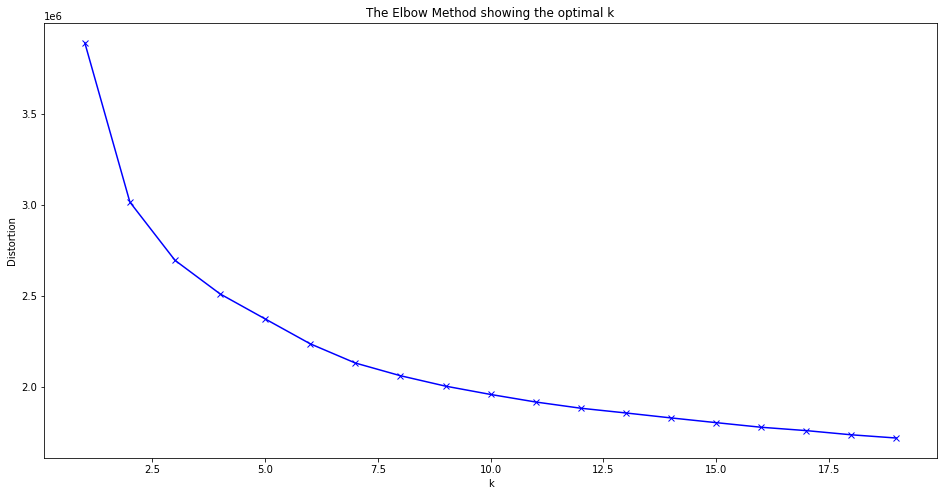

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(playlist[playlist.columns[3:]])
    distortions.append(kmeanModel.inertia_)

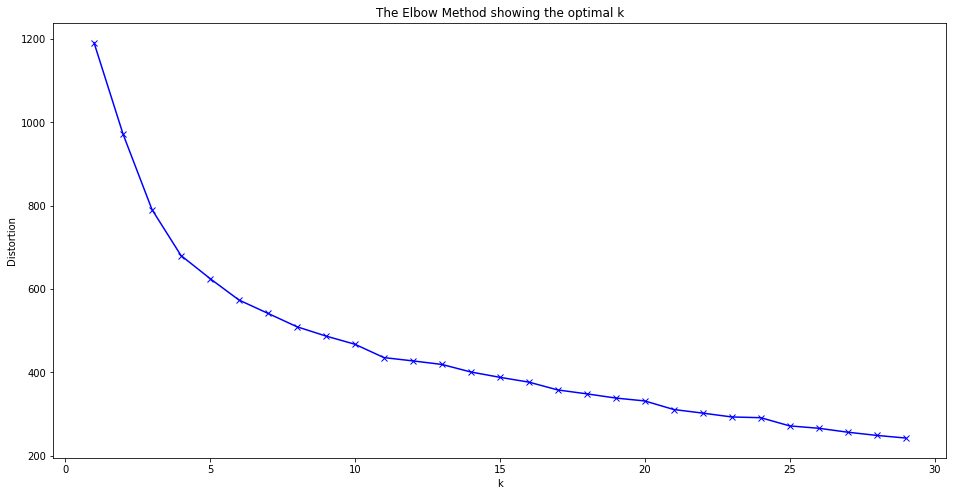

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We saw from the plot, that there appears to be an elbow around K = 6

In [ ]:
K = 6
kmeans = KMeans(init="k-means++", n_clusters=K, random_state=311)
h = make_pipeline(StandardScaler(), kmeans).fit(playlist[playlist.columns[3:]])
pred_clusters = h.predict(playlist[playlist.columns[3:]])

In [ ]:
playlist['kmeans'] = pred_clusters

In [ ]:

#Convert Each of the K Clusters to be either 1 (yes) or -1 (no)
for cluster in [0, 1, 2, 3, 4, 5]:
  curr_cluster = playlist[playlist['kmeans']==cluster]
  curr_cluster

  curr_df = pd.DataFrame()
  sum = 0

  df = playlist[playlist['song_uri'].isin(curr_cluster['song_uri'])]
  good_bad = df['yes/no'].sum()



  if good_bad > 10:
    print(cluster)
    print(good_bad)
    print(curr_cluster.shape[0])
    print('\n')
  else:
    print(cluster)
    print(good_bad)
    print(curr_cluster.shape[0])
    print('\n')
    


0
-10
10


1
-14
14


2
35
61


3
-7
7


4
-6
6


5
-2
2




In [ ]:
clustered_play = playlist

clustered_play['kmeans'] = clustered_play['kmeans'].replace(0,-1)
clustered_play['kmeans'] = clustered_play['kmeans'].replace(1,-1)
clustered_play['kmeans'] = clustered_play['kmeans'].replace(3,-1)
clustered_play['kmeans'] = clustered_play['kmeans'].replace(4,-1)
clustered_play['kmeans'] = clustered_play['kmeans'].replace(5,-1)
clustered_play['kmeans'] = clustered_play['kmeans'].replace(2,1)

clustered_play

,Unnamed: 0,track,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,release_date_2016,release_date_2017,release_date_2018,release_date_2019,release_date_2020,release_date_2021,release_date_2022,yes/no,kmeans,dbc
0,7040,Overwhelming,spotify:track:48LwbDH7u5UMrsY3sjfjhe,1.238386,0.489285,-1.461865,1.043911,0.688884,0.364055,-0.630302,...,1,0,0,0,0,0,0,1,1,1
1,7014,Blu,spotify:track:4FUDWkguOUVpLRAVn5C20z,-0.648126,-0.040137,-1.461865,0.526365,0.688884,-0.460434,-0.531820,...,0,0,1,0,0,0,0,1,1,1
2,3168,Weak,spotify:track:5DZwnLxHjWTZaz9jOpRhxb,0.834133,0.560100,-0.052756,1.039422,0.688884,-0.406879,-0.977582,...,0,1,0,0,0,0,0,1,1,1
3,3149,Burn The House Down,spotify:track:0TkJIyL69RAUIbNwGub6uR,-0.285336,0.617426,-1.461865,1.064556,0.688884,0.117875,-1.189060,...,0,0,1,0,0,0,0,1,1,1
4,76292,3 Nights,spotify:track:0uI7yAKUf52Cn7y3sYyjiX,1.585629,0.138585,0.510888,0.777700,-1.451624,-0.220300,-0.705460,...,0,0,1,0,0,0,0,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,113905,Day One,spotify:track:4WmB04GBqS4xPMYN9dHgBw,-1.026465,-1.549835,1.074532,-1.940057,-1.451624,-0.457411,1.119055,...,0,0,0,0,0,0,0,-1,-1,-1
96,63610,The Real Slim Shady,spotify:track:3yfqSUWxFvZELEM4PmlwIR,2.280114,0.620798,-0.052756,1.079046,-1.451624,-0.360666,-1.205128,...,0,0,0,0,0,0,0,-1,-1,-1
97,63408,Rap God,spotify:track:6or1bKJiZ06IlK0vFvY75k,1.031077,1.234524,0.510888,1.282166,0.688884,0.748443,-0.254514,...,0,0,0,0,0,0,0,-1,-1,1
98,237460,Face Off,spotify:track:6M47gaKejso9772SKTa3yH,0.953336,1.544759,0.792710,1.068916,0.688884,0.359737,-0.816900,...,0,0,0,0,0,1,0,-1,1,-1


In [ ]:
clustered_play['yes/no'].array

<PandasArray>
[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
 -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
 -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
 -1, -1, -1, -1, -1]
Length: 100, dtype: int64

In [ ]:
clustered_play['kmeans'].array

<PandasArray>
[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
 -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
 -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,
 -1, -1, -1,  1, -1]
Length: 100, dtype: int32

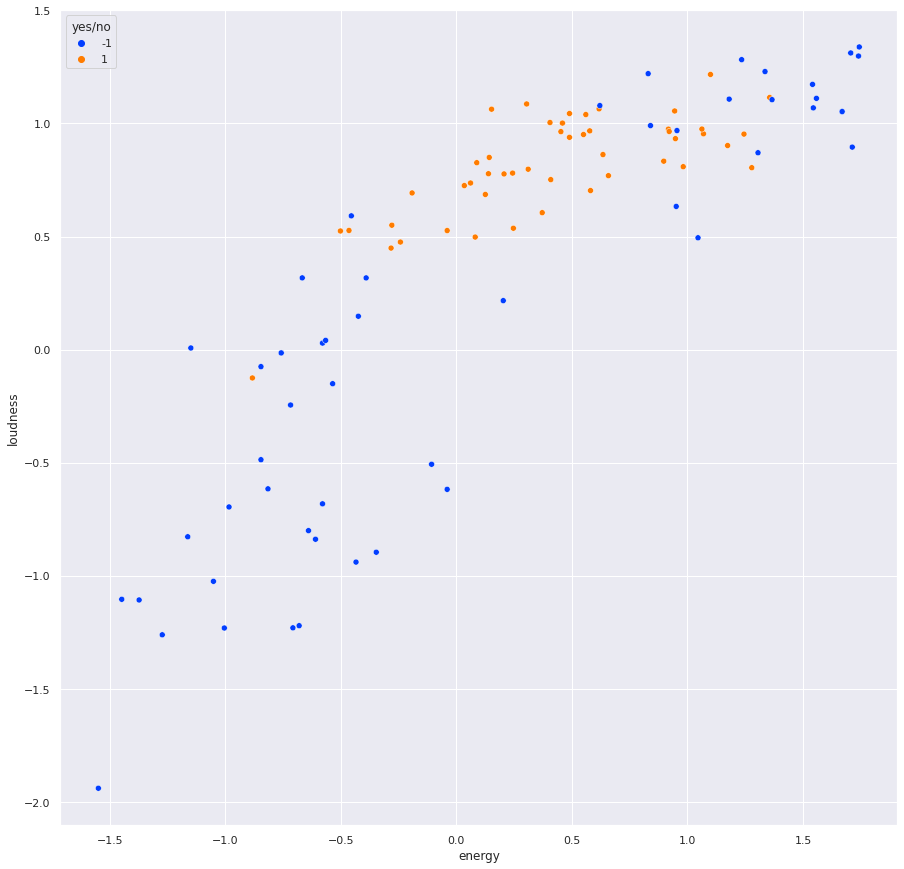

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=playlist['energy'], y=playlist['loudness'], hue=playlist['yes/no'], palette = "bright")

# Actual Clusters of Yes vs No Songs of the playlist data

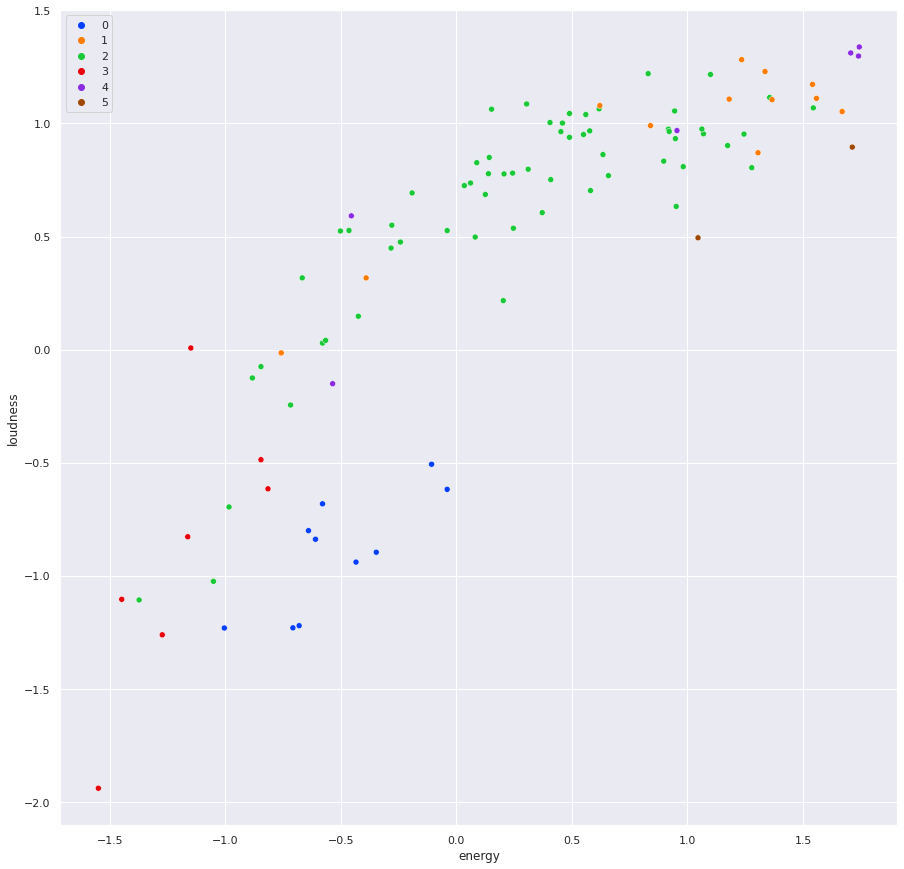

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=playlist['energy'], y=playlist['loudness'], hue=pd.Categorical(pred_clusters), palette = "bright")

# Predicted Clusters using Kmeans of the playlist data

In [ ]:
K=6     # num clusters equals 6 from the elbow method
pred_data = MinMaxScaler().fit_transform(cleaned_df[cleaned_df.columns[3:]])
pred_kmeans = KMeans(init="k-means++", n_clusters=K, random_state=10).fit(pred_data)
cleaned_df['kmeans'] = pred_kmeans.labels_
#all_kmeans = KMeans(init="k-means++", n_clusters = K, random_state = 10)
#all_h = make_pipeline(StandardScaler(), all_kmeans).fit(cleaned_df[cleaned_df.columns[3:]])
#all_pred_clusters = all_h.predict(cleaned_df[cleaned_df.columns[3:]])
#cleaned_df['kmeans'] = all_pred_clusters

In [ ]:
cleaned_df

,Unnamed: 0,track,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,release_date_2015,release_date_2016,release_date_2017,release_date_2018,release_date_2019,release_date_2020,release_date_2021,release_date_2022,yes/no,kmeans
0,0,Alone,spotify:track:3bcPWqX9MFviad9Qzi1JsY,-0.788060,1.129988,-1.461865,0.917730,0.688884,-0.447477,-1.283087,...,0,0,0,0,0,0,1,0,0,5
1,1,Bolts,spotify:track:3f2LhIaP9SNSJATSlRrxxA,-0.202412,0.968126,1.356354,0.928117,-1.451624,-0.393490,-1.283206,...,0,0,0,0,0,0,1,0,0,0
2,2,Control,spotify:track:7faezcZBHx92SToxxuoQ6i,-0.306066,1.315454,0.229066,0.992618,-1.451624,-0.399969,-1.282761,...,0,0,0,0,0,0,1,0,0,0
3,3,Stay,spotify:track:2bW5dcbs58woo1zmYK1xSf,-1.793509,0.044165,0.229066,0.715123,-1.451624,-0.476846,-0.757293,...,0,0,0,0,0,0,1,0,0,0
4,4,Origami,spotify:track:3qpyxgH65qNhJ9hLS2gWrS,-0.135037,1.096267,1.638176,0.794499,0.688884,-0.369304,-1.265176,...,0,0,0,0,0,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278833,278833,The Good In Me,spotify:track:2OrtgstpMFxQk6ZfVqTj48,0.740844,0.179050,0.510888,1.014930,-1.451624,-0.393058,-0.936116,...,0,1,0,0,0,0,0,0,0,0
278834,278834,Morning In America,spotify:track:3NRzGK0pFfhUgU6i3Kg9m3,1.171010,0.634286,-0.052756,0.862462,0.688884,-0.253988,-0.949074,...,0,1,0,0,0,0,0,0,0,5
278835,278835,iRobot,spotify:track:0BcaPJXzQf0uU8XeXdvvgd,-0.684405,0.334168,1.638176,0.988386,0.688884,-0.331729,-0.689910,...,0,1,0,0,0,0,0,0,0,5
278836,278836,Guillotine,spotify:track:2p2aCtErYX6UaFxyfpVvWC,0.336592,1.099639,-0.334578,1.216768,-1.451624,0.195616,-1.019048,...,0,1,0,0,0,0,0,0,0,0


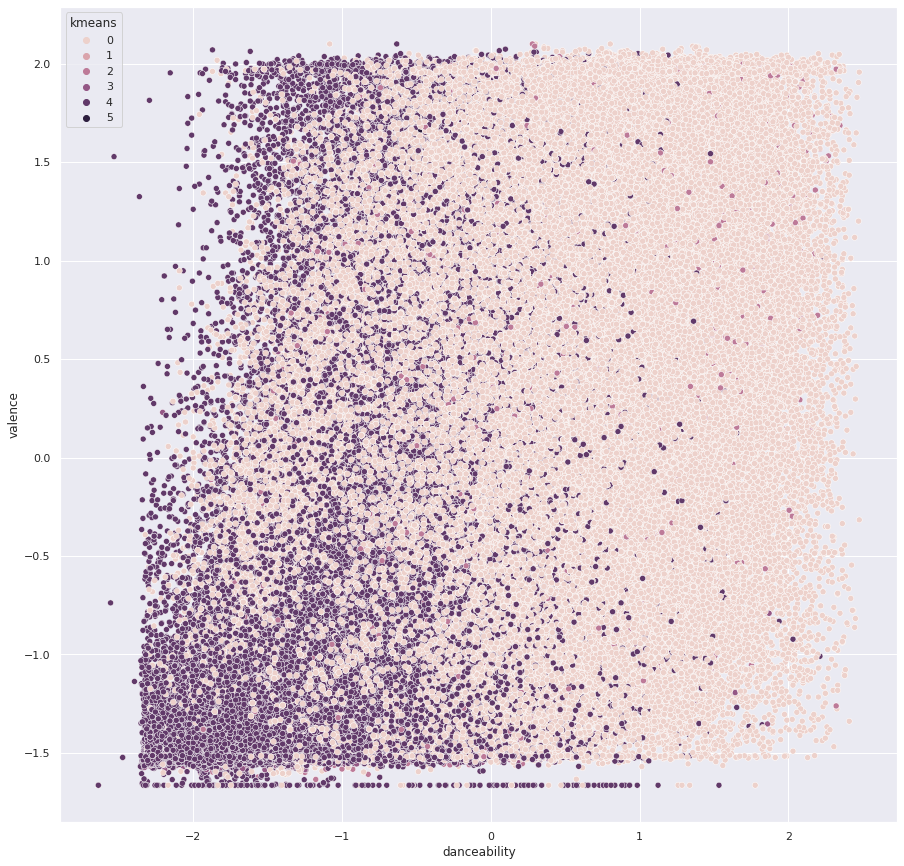

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=cleaned_df['danceability'], y=cleaned_df['valence'], hue=cleaned_df['kmeans'])

# Clusters of the predicted clusters from the cell above

### Model Evaluation

Using the same process as with the playlist, we are looking for the cluster with the most good vs bad songs

Looks like cluster 5 is the one we need

In [ ]:
#Convert Each of the K Clusters to be either 1 (yes) or -1 (no)
for cluster in [0, 1, 2, 3, 4, 5]:
  curr_cluster = cleaned_df[cleaned_df['kmeans']==cluster]
  curr_cluster

  curr_df = pd.DataFrame()
  sum = 0

  df = playlist[playlist['song_uri'].isin(curr_cluster['song_uri'])]
  good_bad = df['yes/no'].sum()



  if good_bad > 10:
    print(cluster)
    print(good_bad)
    print(curr_cluster.shape[0])
    print('\n')
  else:
    print(cluster)
    print(good_bad)
    print(curr_cluster.shape[0])
    print('\n')
    


0
-3
57845


1
-2
19277


2
1
40479


3
-7
61659


4
-10
19004


5
17
80574




In [ ]:
clustered = cleaned_df

clustered['yes/no'] = clustered['kmeans']

clustered['yes/no'] = clustered['yes/no'].replace(0,-1)
clustered['yes/no'] = clustered['yes/no'].replace(1,-1)
clustered['yes/no'] = clustered['yes/no'].replace(2,-1)
clustered['yes/no'] = clustered['yes/no'].replace(3,-1)
clustered['yes/no'] = clustered['yes/no'].replace(4,-1)
clustered['yes/no'] = clustered['yes/no'].replace(5,1)


clustered

,Unnamed: 0,track,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,release_date_2015,release_date_2016,release_date_2017,release_date_2018,release_date_2019,release_date_2020,release_date_2021,release_date_2022,yes/no,kmeans
0,0,Alone,spotify:track:3bcPWqX9MFviad9Qzi1JsY,-0.788060,1.129988,-1.461865,0.917730,0.688884,-0.447477,-1.283087,...,0,0,0,0,0,0,1,0,1,5
1,1,Bolts,spotify:track:3f2LhIaP9SNSJATSlRrxxA,-0.202412,0.968126,1.356354,0.928117,-1.451624,-0.393490,-1.283206,...,0,0,0,0,0,0,1,0,-1,0
2,2,Control,spotify:track:7faezcZBHx92SToxxuoQ6i,-0.306066,1.315454,0.229066,0.992618,-1.451624,-0.399969,-1.282761,...,0,0,0,0,0,0,1,0,-1,0
3,3,Stay,spotify:track:2bW5dcbs58woo1zmYK1xSf,-1.793509,0.044165,0.229066,0.715123,-1.451624,-0.476846,-0.757293,...,0,0,0,0,0,0,1,0,-1,0
4,4,Origami,spotify:track:3qpyxgH65qNhJ9hLS2gWrS,-0.135037,1.096267,1.638176,0.794499,0.688884,-0.369304,-1.265176,...,0,0,0,0,0,0,1,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278833,278833,The Good In Me,spotify:track:2OrtgstpMFxQk6ZfVqTj48,0.740844,0.179050,0.510888,1.014930,-1.451624,-0.393058,-0.936116,...,0,1,0,0,0,0,0,0,-1,0
278834,278834,Morning In America,spotify:track:3NRzGK0pFfhUgU6i3Kg9m3,1.171010,0.634286,-0.052756,0.862462,0.688884,-0.253988,-0.949074,...,0,1,0,0,0,0,0,0,1,5
278835,278835,iRobot,spotify:track:0BcaPJXzQf0uU8XeXdvvgd,-0.684405,0.334168,1.638176,0.988386,0.688884,-0.331729,-0.689910,...,0,1,0,0,0,0,0,0,1,5
278836,278836,Guillotine,spotify:track:2p2aCtErYX6UaFxyfpVvWC,0.336592,1.099639,-0.334578,1.216768,-1.451624,0.195616,-1.019048,...,0,1,0,0,0,0,0,0,-1,0


In [ ]:
recommended = cleaned_df[cleaned_df['yes/no']==1]
recommended

,Unnamed: 0,track,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,release_date_2015,release_date_2016,release_date_2017,release_date_2018,release_date_2019,release_date_2020,release_date_2021,release_date_2022,yes/no,kmeans
0,0,Alone,spotify:track:3bcPWqX9MFviad9Qzi1JsY,-0.788060,1.129988,-1.461865,0.917730,0.688884,-0.447477,-1.283087,...,0,0,0,0,0,0,1,0,1,5
4,4,Origami,spotify:track:3qpyxgH65qNhJ9hLS2gWrS,-0.135037,1.096267,1.638176,0.794499,0.688884,-0.369304,-1.265176,...,0,0,0,0,0,0,1,0,1,5
6,6,Call Me When You Get There,spotify:track:6PbzyKi3twLBNna3shMjEe,0.632007,1.055801,0.792710,0.885159,0.688884,-0.393058,-1.276968,...,0,0,0,0,0,0,1,0,1,5
9,9,Cynical,spotify:track:7IS35Ak2fvABOXVua4t77r,-0.010651,1.106383,0.510888,0.903624,0.688884,-0.389603,-1.282621,...,0,0,0,0,0,0,1,0,1,5
10,10,Set It Right,spotify:track:0xWentwc07d6FVKmFe3SOd,-0.694771,1.339059,0.229066,0.948762,0.688884,-0.402560,-1.283064,...,0,0,0,0,0,0,1,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278829,278829,Maybe IDK,spotify:track:6vBVh1k61VCdJ7StOOlHJO,0.160379,0.212771,1.074532,0.787574,0.688884,-0.374919,-1.123750,...,0,1,0,0,0,0,0,0,1,5
278830,278830,Woke The F*ck Up,spotify:track:5jKMjgG0J08rCezDvAX0sn,0.922240,0.489285,0.792710,0.938760,0.688884,-0.181429,-1.178175,...,0,1,0,0,0,0,0,0,1,5
278831,278831,Overwhelming,spotify:track:498lAnNuuwNqtR3iM0ljBN,1.238386,0.489285,-1.461865,1.043911,0.688884,0.364055,-0.630302,...,0,1,0,0,0,0,0,0,1,5
278834,278834,Morning In America,spotify:track:3NRzGK0pFfhUgU6i3Kg9m3,1.171010,0.634286,-0.052756,0.862462,0.688884,-0.253988,-0.949074,...,0,1,0,0,0,0,0,0,1,5


In [ ]:
uris = recommended['song_uri']

sampled = uris.sample(n=100)
sampled
for s in sampled:
  song = cleaned_df[cleaned_df['song_uri']==s]
  #print(song[['artist', 'track']])

To Determine which songs are liked and disliked, we are going to look at each cluster individually and look through all the songs for songs in our playlist. If we added up the 1's and -1's from the songs in the playlist, we will get whetehr or not there are more liked or disliked songs in a cluster. If a cluster has 10 or more liked songs than disliked songs, we made the whole cluster liked songs. This gave us around 87,000 recommended songs, which is about 15% of all songs we collected. We wanted to try to be more selective.

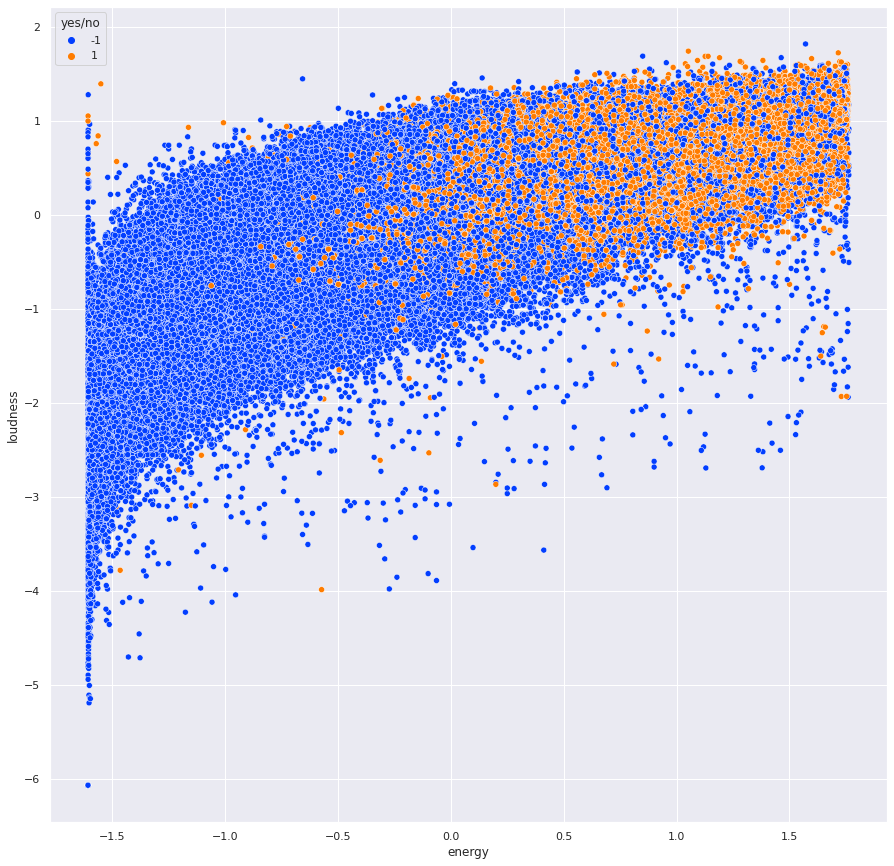

In [ ]:
sampled_df = cleaned_df #recommended.sample(n=100)
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=sampled_df['energy'], y=sampled_df['loudness'], hue=sampled_df['yes/no'], palette = "bright")

We see from the above plot, that the general trend of the cluster of recommended songs, roughly relates to the scatterplot of the actual liked songs. Therefore, we can say that there is decent accuracy. 

## Using Euclidean Distance to Cluster

  - Requires only a good playlist
  - Makes use of a threshold

After finding the mean value of liked songs. Calculate the distance from liked songs in our playlist to that mean value. From those distances we will create a threshold to use. The average distance will be our threshold. Meaning that a song must be less than or equal to the mean distance of liked songs to be considered a liked song. If a song doesn't meet that threshold it is considered a disliked song

In [ ]:
# Density Based Clustering

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

data = MinMaxScaler().fit_transform(playlist[playlist.columns[3:]])

dbc = DBSCAN(eps=2.25, min_samples=50).fit(data)
playlist['dbc'] = dbc.labels_
playlist

In [ ]:
playlist['dbc'] = playlist['dbc'].replace(0, 1)
playlist

,Unnamed: 0,track,song_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,release_date_2016,release_date_2017,release_date_2018,release_date_2019,release_date_2020,release_date_2021,release_date_2022,yes/no,kmeans,dbc
0,7040,Overwhelming,spotify:track:48LwbDH7u5UMrsY3sjfjhe,1.238386,0.489285,-1.461865,1.043911,0.688884,0.364055,-0.630302,...,1,0,0,0,0,0,0,1,2,1
1,7014,Blu,spotify:track:4FUDWkguOUVpLRAVn5C20z,-0.648126,-0.040137,-1.461865,0.526365,0.688884,-0.460434,-0.531820,...,0,0,1,0,0,0,0,1,2,1
2,3168,Weak,spotify:track:5DZwnLxHjWTZaz9jOpRhxb,0.834133,0.560100,-0.052756,1.039422,0.688884,-0.406879,-0.977582,...,0,1,0,0,0,0,0,1,2,1
3,3149,Burn The House Down,spotify:track:0TkJIyL69RAUIbNwGub6uR,-0.285336,0.617426,-1.461865,1.064556,0.688884,0.117875,-1.189060,...,0,0,1,0,0,0,0,1,2,1
4,76292,3 Nights,spotify:track:0uI7yAKUf52Cn7y3sYyjiX,1.585629,0.138585,0.510888,0.777700,-1.451624,-0.220300,-0.705460,...,0,0,1,0,0,0,0,1,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,113905,Day One,spotify:track:4WmB04GBqS4xPMYN9dHgBw,-1.026465,-1.549835,1.074532,-1.940057,-1.451624,-0.457411,1.119055,...,0,0,0,0,0,0,0,-1,3,-1
96,63610,The Real Slim Shady,spotify:track:3yfqSUWxFvZELEM4PmlwIR,2.280114,0.620798,-0.052756,1.079046,-1.451624,-0.360666,-1.205128,...,0,0,0,0,0,0,0,-1,1,-1
97,63408,Rap God,spotify:track:6or1bKJiZ06IlK0vFvY75k,1.031077,1.234524,0.510888,1.282166,0.688884,0.748443,-0.254514,...,0,0,0,0,0,0,0,-1,1,1
98,237460,Face Off,spotify:track:6M47gaKejso9772SKTa3yH,0.953336,1.544759,0.792710,1.068916,0.688884,0.359737,-0.816900,...,0,0,0,0,0,1,0,-1,2,-1


In [ ]:
playlist['yes/no'].array

<PandasArray>
[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
 -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
 -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
 -1, -1, -1, -1, -1]
Length: 100, dtype: int64

The above density based clustering clusters the most dense similar data into clusters. The idea was to use these clusters means to see which songs had the shortest euclidean distance to which mean. If that song was within a specified threshold to that mean centroid, then it would be added to that cluster.

In [ ]:
subdf = df.iloc[:,3:]
cleaned_df = cleaned_df.iloc[:,3:]
cleaned_df

In [ ]:
#find all column means of the df
import numpy as np

colMeans = subdf.mean(axis = 0)

# find avg euc distance 
i=0
compareVals = []
meanSong = []
#iterate through each song trait
for column in subdf:
  rowAvg = []
  newdf = subdf[column]
  for ind in newdf.index:
    val = newdf.loc[ind]
    eucDist = (val - colMeans[i])**2
    rowAvg.append(eucDist)
    # print(eucDist)
  avg = mean(rowAvg)
  compareVals.append(avg)
  meanSong.append(colMeans[i])
  i = i+1
compareVals

allsongs = cleaned_df

length = int(cleaned_df.shape[0]/4)
songSet1 = allsongs.iloc[:length]
songSet2 = allsongs.iloc[length:2*length]
songSet3 = allsongs.iloc[2*length:3*length]
songSet4 = allsongs.iloc[3*length:4*length]

recommendedSongs = []
songDistance = []
# sum = math.fsum(compareVals)
compareSum  = np.array(compareVals).sum()
meanSum = np.array(meanSong).sum()
upperSum = compareSum/10 + meanSum
lowerSum = meanSum - compareSum/10

In [ ]:
#compare each song to our average 
for ind in songSet1.index:
  song = np.array(songSet1.loc[ind])
  songSum = song.sum()
  #if our song is in range add song to list of recommended songs
  if songSum>lowerSum:
    if songSum<upperSum:
      recommendedSongs.append(cleaned_df.loc[ind])
      songDistance.append(eucDist)

In [ ]:
#compare each song to our average 
for ind in songSet2.index:
  song = songSet2.loc[ind]
  a = np.array(song)
  b = np.array(meanSong)
  eucDist = np.linalg.norm(a-b)
  #if our song is in range add song to list of recommended songs
  if songSum>lowerSum:
    if songSum<upperSum:
      recommendedSongs.append(cleaned_df.loc[ind+length])
      songDistance.append(eucDist)

In [ ]:
#compare each song to our average 
for ind in songSet3.index:
  song = songSet3.loc[ind]
  a = np.array(song)
  b = np.array(meanSong)
  eucDist = np.linalg.norm(a-b)
  #if our song is in range add song to list of recommended songs
  if songSum>lowerSum:
    if songSum<upperSum:
      recommendedSongs.append(cleaned_df.loc[ind+2*length])
      songDistance.append(eucDist)

In [ ]:
#compare each song to our average 
for ind in songSet4.index:
  song = songSet4.loc[ind]
  a = np.array(song)
  b = np.array(meanSong)
  eucDist = np.linalg.norm(a-b)
  #if our song is in range add song to list of recommended songs
  if songSum>lowerSum:
    if songSum<upperSum:
      recommendedSongs.append(cleaned_df.loc[ind+3*length])
      songDistance.append(eucDist)

In [ ]:
recommended_df = pd.DataFrame.from_records(recommendedSongs)
recommended_df

In [ ]:
z = recommended_df.sample(n=10)
z

This was the last approach we tried. The idea was promising, however we just didn't have enough time to complete it in its entirety. Thus, we decided to go with the Kmeans clustering approach

## Clustering Model

  - At this point:
  - We have all songs saved in cleaned_df
  - We have playlist songs saved in playlist
  - Chosen Model : KMeans

The code for the kmeans clustering is above. We went with this model, because it gave us the best outputs. It gave a lot of song recommendations, but compared with the other models, it gave better results. 